- Yahoo Finance 에서 주가 데이터 다운로드 (https://finance.yahoo.com/)
- 검색 후 Historical Data 선택
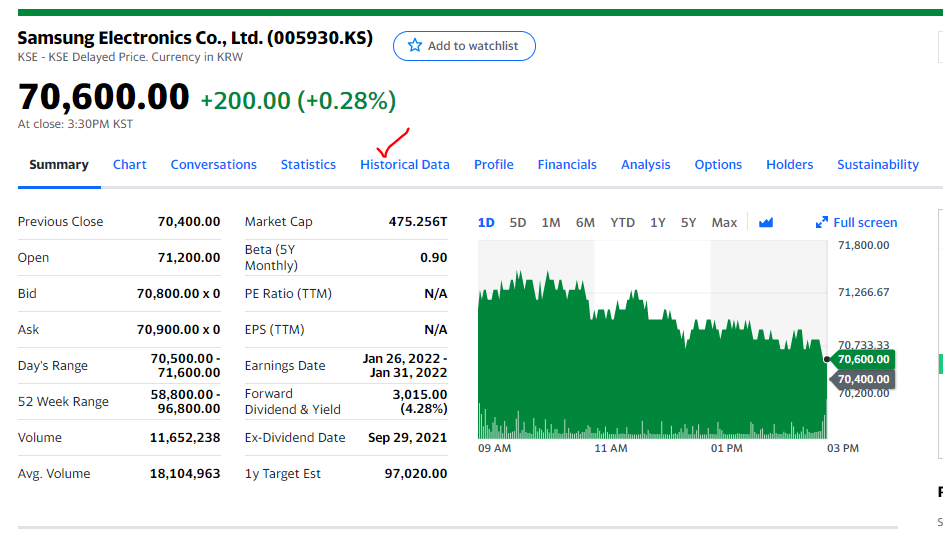

- 기간 선택 후 Apply -> Download 클릭
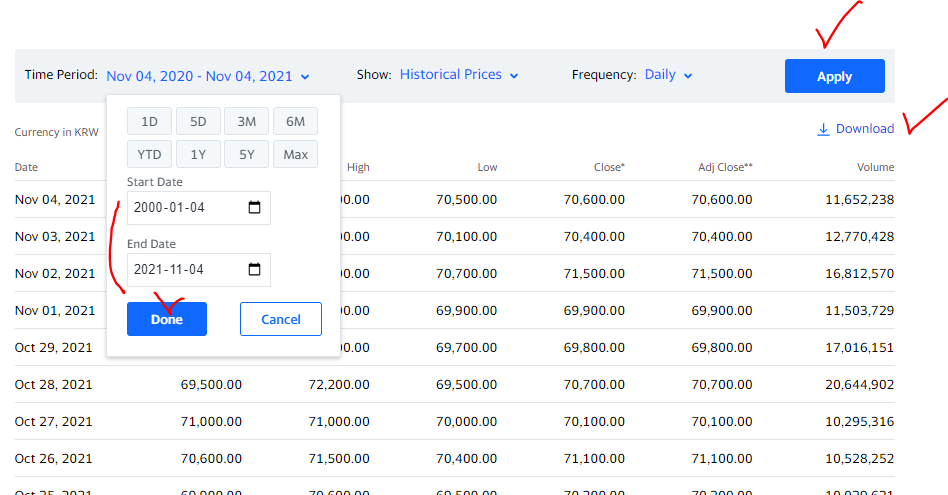

##### Data Loading 및 확인

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('005930.KS.csv')
df.shape

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df.isnull().sum()

In [ ]:
df.loc[df.Open.isnull()]

##### 전처리
- date를 index
- 결측치 제거
- Adj Close 컬럼 제거
- MinMaxScaling

In [ ]:
df['Date'] = pd.to_datetime(df.Date)
df.info()

In [ ]:
df.set_index('Date', inplace=True)

In [ ]:
df.head()

In [ ]:
df[['Open', 'Close']].plot(figsize=(20,5));

In [ ]:
df[['Open', 'Close']].iloc[:30].plot(figsize=(20,5));

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.drop(columns=['Adj Close'], inplace=True)

In [ ]:
df.head()

### X, y 분리

In [ ]:
df_y = df['Close'].to_frame()

df_X = df   

In [ ]:
df_y.plot(figsize=(15,5));

### Scaling - MinMaxScaler
- Scaler를 X, y 용 따로 만든다.
    - y를 inverse 하기 위해

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X = scaler_X.fit_transform(df_X)
y = scaler_Y.fit_transform(df_y)

##  날짜 종가 예측
- X: 50일치 주가(ex:1일 ~ 50일), y: 51일째 주가. (ex: 51일)
    - 50일의 연속된 주식가격을 할습하여 51일째 주가를 예측한다.
    - X의 한개의 데이터가 50일치 주가가 된다.
<br>

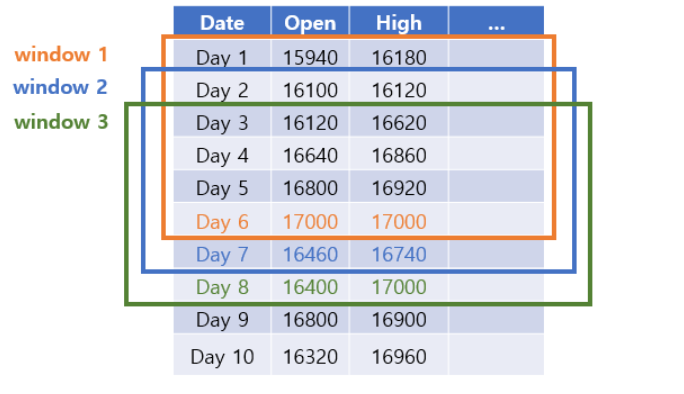
<center>[연속된 날짜가 5인 경우]</center>

X, y를 만든다.
각 index에 window size의 데이터셋이 들어가도록 한다.

In [ ]:
print(X.shape, y.shape, type(X), y.size, len(y))

##### input sequence dataset 만들기

In [ ]:
window_size = 50
data_X = []
data_y = []

for i in range(0, y.size-window_size):
    _X = X[i:i+window_size]
    _y = y[i+window_size]
    data_X.append(_X)
    data_y.append(_y)

In [ ]:
np.shape(data_X), np.shape(data_y)

## Train, Test 분리
- Train : 8, Test: 2의 비율로 나눈다.

In [ ]:
train_size = int(len(data_y) * 0.8)
test_size = len(data_y) - train_size
print(train_size, test_size, train_size+test_size)

In [ ]:
X_train = np.array(data_X[:train_size])
X_test = np.array(data_X[train_size:])

y_train = np.array(data_y[:train_size])
y_test = np.array(data_y[train_size:])

X_train.shape, X_test.shape, y_train.shape, y_test.shape

##### import

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np

np.random.seed(0)
tf.random.set_seed(0)

##### 하이퍼파라미터 정의

In [ ]:
LEARNING_RATE = 0.001
N_EPOCHS = 100
N_BATCHS = 100

N_TRAIN = X_train.shape[0]
N_TEST = X_test.shape[0]

##### Dataset 생성 

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
                               .shuffle(N_TRAIN)\
                               .batch(N_BATCHS, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(N_BATCHS)

## Model 생성

- LSTM 레이어는 return_sequences 인자에 따라 마지막 시퀀스에서 한 번만 출력할 수 있고 각 시퀀스에서 출력을 할 수 있다. 
    - return_sequences=True: 시퀀스마다 결과를 출력. False(기본값): 전체 Sequence를 처리하고 결과를 하나만 출력
- many to many 문제를 풀거나 LSTM 레이어를 여러개로 쌓아올릴 때는 return_sequence=True 옵션을 사용. 
- Fully Connected Layer(Dense)와 연결된 경우 return_sequence=False로 해서 하나만 전달.
- 아래 그림에서 왼쪽은 return_sequences=False일 때, 오른쪽은 return_sequence=True일 때의 형상.

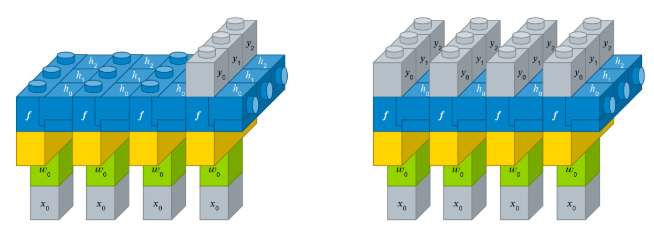

<center>[출처: https://tykimos.github.io/2017/04/09/RNN_Getting_Started]</center>

##### 모델 생성, 컴파일

In [ ]:
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(window_size, 5)))
    model.add(keras.layers.LSTM(32, return_sequences = False, activation="tanh"))            
    
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dense(1)) 
    
    return model

In [ ]:
model = create_model()
model.compile(optimizer=keras.optimizers.Adam(LEARNING_RATE), loss='mse')
model.summary()

##### 모델 학습, 평가

In [ ]:
hist = model.fit(train_dataset, epochs=N_EPOCHS, validation_data=test_dataset)

##### 결과 시각화

In [ ]:
plt.plot(range(1, N_EPOCHS+1), hist.history['loss'], label='loss')
plt.plot(range(1, N_EPOCHS+1), hist.history['val_loss'], label='val_loss')
plt.legend()
plt.ylim(0,0.05)
plt.show()

##### 최종평가

In [ ]:
test_loss = model.evaluate(X_test, y_test)

##### 다음날 주가 예측
- 마지막 50일치로 내일 주가를 예측해 본다.

In [ ]:
new_data = X[-50:]
new_data = new_data[np.newaxis, ...]
new_data.shape

In [ ]:
pred = model.predict(new_data)

In [ ]:
pred

In [ ]:
scaler_Y.inverse_transform(pred) 